In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypinyin import lazy_pinyin, Style  # 注音拼音轉換 套件
import re
from unicodedata import normalize        # 半形轉換 套件
from scipy.sparse import csc_matrix

df = pd.read_csv('data/interview_data.csv')
df.is_ad = df.is_ad.map({'N': 0, 'Y':1}) # y 轉換成 {0, 1}

# 觀察廣告訊息與字串長度關係

可以看到廣告訊息長度大多在40以上，可以猜想將長度作為特徵可以提升precision, $=P(Y=1|\hat{y}=1)$

也就是我們不容易將太短的訊息視為廣告(type II error, 假當真)

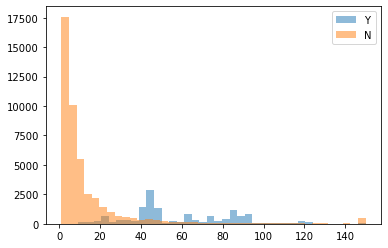

In [2]:
df['len'] = df['content'].str.len()
n = 150
plt.hist(np.minimum(n, df.len[df.is_ad == 1]),
         bins=40, alpha=0.5, label='Y')
plt.hist(np.minimum(n, df.len[df.is_ad == 0]), 
         bins=40, alpha=0.5, label='N')
plt.legend()
del df['len']

前處理
----

大方向上對字元、字串做以下編碼：

* **中文換成注音向量(onehot)和聲調向量加總**, ex: 我 → ㄨ向量 + ㄛ向量 + \[0...0,3,0\]
* **連續的英文數字混合字串編碼成長度**, ex: nb682le → \[0...0,7\]
* **編碼已知單字(onehot)**,ex: line → \[0...0,1,0,0\]

得到一條41維向量. ie.**\[37注音,斷句符號,單字line,聲調,英數長度\]**

前39維boolean, 後兩維是整數

會這樣編碼有以下理由：

* 中文字太多，導致onehot效益差。往往需要別人預訓練的向量(ex: BERT...)
* 廣告訊息為規避檢查，會有許多非日常用字，預訓練模型不好泛化到這個資料集
* 廣告文常利用諧音，在規避檢查的同時發佈訊息。因此這些文字在拼音維度上是相似的
* 除特殊單字外如 標的編碼, LineID 不具有區別意義，把它看成一個整體，紀錄長度就可以了

實際步驟：

1. 轉半形小寫
2. 斷句符號 → `\n` 
3. `+`  → `加`
4. `#`,` ` → 空字串
5. `line` → `#`
6. `a-z`, `0-9` → `1`

In [3]:
df.content = df.content.apply( lambda x: normalize('NFKC', x) ) \
                       .str.lower() \
                       .str.replace(r'[\t\n\r\f\v!?,.]', '\n') \
                       .str.replace( '+'  , '加')\
                       .str.replace(r'[# ]', '') \
                       .str.replace( 'line', '#')\
                       .str.replace(r'[a-z0-9]', '1')

# 以下分兩種方式替換注音

1. [聲母化](#initialize)：保留聲母部分. ex: 家瀨, 加萊 → ㄐㄌ

    * [特徵提取](#featurework)後用於[模型一](model1.ipynb)(Tree)
    

2. [注音化](#bopomofize)：注音全部保留

    * 用於[模型二](model2.ipynb)(深度學習)


從`中文` → `注音`等於混淆了同音字

而`注音` → `聲母`等於又混淆了同聲字([注音文](https://zh.wikipedia.org/wiki/%E6%B3%A8%E9%9F%B3%E6%96%87)保留了某種程度的訊息)

比起韻母，聲母具備更多資訊，諧音有很大機會具有相同聲母，並且聲母化的資料較結構化，方便特徵提取。

<a id='initialize'></a>
# 聲母化

In [4]:
def initialization(string, style=Style.BOPOMOFO_FIRST):
    return ''.join(  lazy_pinyin(string, style=style)  )

# 聲母化
df['initials'] = df.content.apply(initialization)
df.head()

,content,is_ad,initials
0,朋友爲什麼要道歉\n,0,ㄆㄧㄨㄕㄇㄧㄉㄑ\n
1,新建股票社團\n現在限時免費加入\n群中有版主教學並且報牌\n進社裙的加我賴11111111111,1,ㄒㄐㄍㄆㄕㄊ\nㄒㄗㄒㄕㄇㄈㄐㄖ\nㄑㄓㄧㄅㄓㄐㄒㄅㄑㄅㄆ\nㄐㄕㄑㄉㄐㄨㄌ11111111111
2,謝謝🙏,0,ㄒㄒ🙏
3,1,0,1
4,綠能對台灣而言是最珍貴\n現在不開發\n難道又要等通貨膨脹再來補救\n已經來不及了\n,0,ㄌㄋㄉㄊㄨㄦㄧㄕㄗㄓㄍ\nㄒㄗㄅㄎㄈ\nㄋㄉㄧㄧㄉㄊㄏㄆㄓㄗㄌㄅㄐ\nㄧㄐㄌㄅㄐㄌ\n


<a id='featurework'></a>

特徵提取
----

把簡單的 regex 作特徵就可以有很好的召回率(recall):

* `ㄐㄨ?ㄌㄑ?1+` ~= `加(我)賴(群)ooxx123`
* `1{5,}` = `長度5以上的英文數字` ~= `anj56eex` ~= LineID
* `ㄑㄗ` ~= `群組`
* `ㄕㄊ` ~= `社團`
* `ㄊㄌ` ~= `討論`
* `(1+)` ~= `(tw123)`
* `#` = `line`

以這些和訊息`長度`為特徵，有了[模型一](model1.ipynb)

衡量訊息長度和內含訊息組合，其實是 term frequency 的概念

找出可以區分廣告訊息的字眼，其實是 inverse document frequency 的概念

這樣其實可以說是某種形式上的 [tf-idf](https://zh.wikipedia.org/wiki/Tf-idf) 類方法

*Detail*
----

* 這些特徵被選出來背後的想法是：**廣告訊息有特定樣式**，非廣告訊息則是雜亂無章的。所以我們要找廣告的特徵，而不找非廣告的特徵。

* 因此在這個階段，只要有任一特徵都猜是廣告，涵蓋盡可能多的真實廣告(recall 高)，在模型階段再去組合這些特徵。
    
* 因為這些特徵是基於**廣告訊息**被挑選出來的，所以在模型階段很難因為**沒有某一特徵**去猜它是廣告，通常只會在這些疑似廣告的樣本中挑選出信心更高的子集，也因此召回率只會降低。又再次說明了在這個階段要盡可能提高召回率。

* 在模型階段，目標會是在提高精確度(precision)的同時不要讓召回率(recall)下降太多，因此開頭提到的`長度`會是一個很好的特徵，`長度`長的訊息會有較高的信心是廣告。

表現
---

可以看到用含有 (`ㄕㄊ` 或 `長度5以上的英文數字`) 這條規則，就可以捕捉到大部分的廣告。

In [5]:
def performance(regex):
    suspect = df.initials.str.contains(regex)
    confusion = (suspect * 2 + df.is_ad).value_counts().sort_index()
    print("""
         \     Is AD
          \   N     Y
           o-----+-----o
         0 |{0:5d}|{1:5d}|
     pred  +-----+-----+
         1 |{2:5d}|{3:5d}|
           o-----+-----o  """.format(*confusion.values) )
    return suspect
    
suspect = performance(r'ㄕㄊ|1{5,}') #`ㄕㄊ`(社團) 或 `5個以上英文數字`(類LineID)
performance(r'ㄐㄨ?ㄌ|ㄑㄗ|ㄊㄌ|#|:|1{5,}') # 選取更多特徵, 召回率更高
# 可以從沒檢查到的去觀察新規則, 或是找出標註錯誤的.
with pd.option_context('display.max_rows', None): 
    display(pd.read_csv('interview_data.csv')[(suspect == 0) & (df.is_ad == 1)])


         \     Is AD
          \   N     Y
           o-----+-----o
         0 |42414|   93|
     pred  +-----+-----+
         1 | 3109|14384|
           o-----+-----o  

         \     Is AD
          \   N     Y
           o-----+-----o
         0 |40737|   74|
     pred  +-----+-----+
         1 | 4786|14403|
           o-----+-----o  


,content,is_ad
534,大戶到底是有多討厭鴻海，拉個兩塊就急著賣XDDD,Y
909,不去羨慕飆股的一時大起，數十年如一日的穩定，讓我睡的著吃的下,Y
1288,不知道為什麼一直飆漲\n\n我只知道這邊一堆看空的\n\n根本都美德的末段班😂😂😂\n\n這...,Y
1707,這2天應該會休息、洗一洗籌碼！🧐🧐🧐,Y
1921,笑死看不起菜籃族喔\n知道三月進場的大媽現在賺多少嗎,Y
2150,哈哈哈⋯應該是在地的券商有實際瞭解公司燈火通明的狀況，領先佈局🧐,Y
2836,請問各位大大創惟被警示多日會不會分盤交易？,Y
3277,業績優配息和利，為什麼常被當沖課沖下來，真的有那麼急嗎？,Y
3516,67.9出完；66.8再進場,Y
4183,依照歷史的資料來說，現在價位還有上漲的空間，沒有急著用錢可以先放著,Y


最後用了這些特徵

In [6]:
# 內文特徵
content_feature = [
    '群',
    'line'
]
# 注音文特徵
initials_feature = [
    '1{5,}',       # ID (5以上英數字串)
    'ㄕㄊ',        # 社團
    'ㄐㄨ?ㄌ',     # 加(我)賴
    'ㄑㄗ',        # 群組
    'ㄊㄌ',        # 討論
    '\(1{3,4}\)'  # 股票代號, ex: 群創(3481)
]

<a id='bopomofize'></a>
# 注音化

* 要注意有些訊息中本來就含有注音，要視為一個單位

* 如上面所說，轉成 41 維向量 **\[37注音,斷句符號,單字line,聲調,英數長度\]**


### 編碼規則

1. onehot

    * `ㄅ`\~`ㄩ` → 0\~36 維
    * `\n+` → 37 維
    * `#` → 38 維

2. 整數型

    * `聲調n` → 39 維
    * `123abcd` → 40 維

In [5]:
#拆解一個注音
word = re.compile(r'([ㄅ-ㄩ]+)([ˊˇˋ˙]?)').fullmatch

#拆解 [換行字元, #, 單注音, 非以上字元組成的序列 ]   `#` = `line`
sent = re.compile(r'(\n+)|(\#)|([ㄅ-ㄩ])|([a-z0-9]+)').finditer  

ZERO = np.zeros(shape=(41,), dtype=np.int32)

def bopomofo2vec(group): 
    vec = ZERO.copy()
    for c in group(1):
        vec[ord(c) - 12549] = 1
    if group(2):    # 如果有聲調
        vec[-2] = 1 + '˙ˊˇˋ'.index(group(2))
    return vec

def sentence_encode(chinese, style=Style.BOPOMOFO):
    seq = [ ZERO ]
    for string in lazy_pinyin(chinese, style=style):
        bopomo_match = word(string)
        if bopomo_match:               # 如果是一組拼音
            seq.append( bopomofo2vec(bopomo_match.group) )
        else:
            for match in sent(string):
                code = ZERO.copy()
                if match.group(1):     # `\n`   ---> 37
                    code[37] = 1
                elif match.group(2):   # `line` ---> 38
                    code[38] = 1
                elif match.group(3):   # `ㄇ`   --->  3
                    code[ ord(match.group(3)) - 12549] = 1
                else:                  # `a123` --->  4
                    code[-1] = len(match.group(4))
                seq.append( code )
    return csc_matrix(seq)


lazy_pinyin('便利auㄅ便宜', style=Style.BOPOMOFO)
# >>> ['ㄅㄧㄢˋ', 'ㄌㄧˋ', 'auㄅ', 'ㄆㄧㄢˊ', 'ㄧˊ']  
# 分別用    word,    word,   sent,     word,  word 處理
bopomofo2vec(word('ㄆㄧㄢˊ').group)
# >>> [0, 1, ..., 2, 0]
sentence_encode('股票名師\n加群:abc11223').toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 